In [1]:
import numpy as np
import scipy.io as scio # load mat file
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d

from PSO import *  # demo PSO codes!

import matplotlib.pyplot as plt

In [2]:
# load data
TrainingData = scio.loadmat('TrainingData.mat')
analysisData = scio.loadmat('analysisData.mat')

## Preparing
dataY = analysisData['dataVec'][0] # (2048,)
# Data length
nSamples = dataY.size # 2048
# Sampling frequency
Fs = analysisData['sampFreq'][0,0] # 1024

# Search range of phase coefficients
rmin = [40, 1, 1]
rmax = [100, 50, 15]

# Noise realization: PSD estimated from TrainingData
dt = 1/Fs
t = np.arange(0, nSamples*dt, dt) # (2048,)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2 # Nyquist frequency
f = np.arange(0, Nyq+df, df) # Not used...(Herb)
[f, pxx1] = welch(TrainingData['trainData'][0], fs=Fs, 
                 window='hamming', nperseg=Fs/2, 
                 noverlap=None, nfft=None, 
                 detrend=False) #This is one-side PSD
pxx=pxx1/2#This is two-side PSD
# Why 'detrend=False'? 
# See https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
# or https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

# Smooth the PSD estimate
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b,1,pxx)
# PSD must be supplied at DFT frequencies.
kNyq = np.floor(nSamples/2) + 1
posFreq = np.arange(0, kNyq)*Fs/nSamples
psdPosFreq = interp1d(f,pxxSmth)(posFreq)

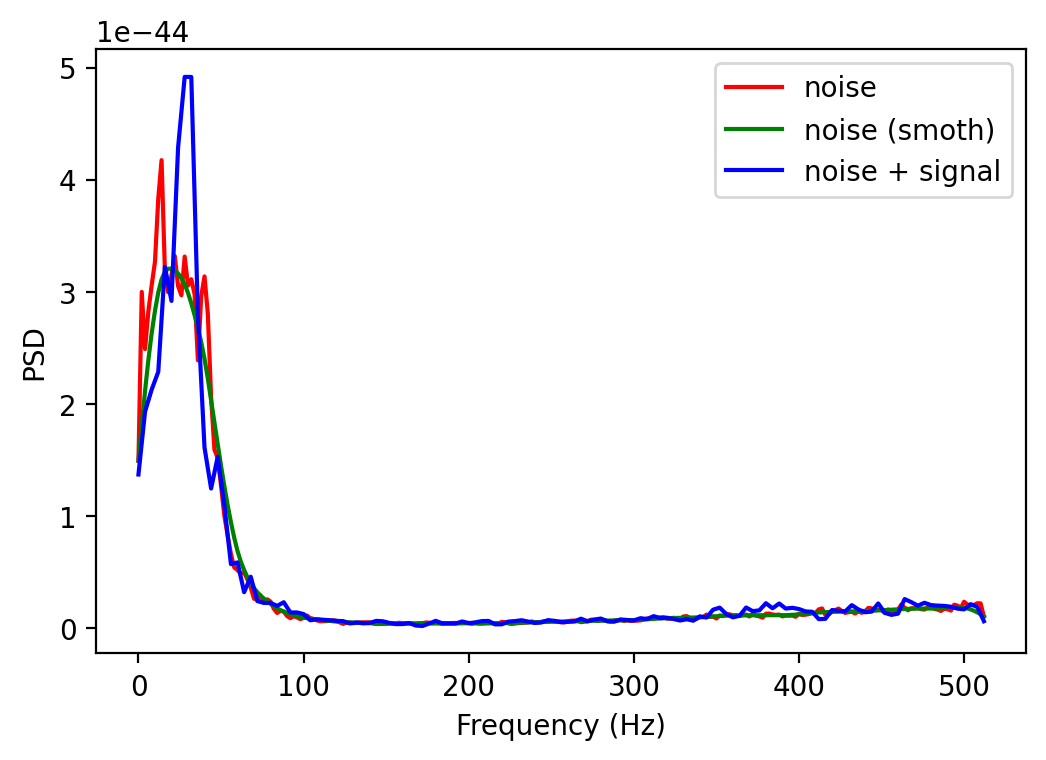

In [3]:
# Plot PSDs for the noise and noise + signal.
plt.figure(dpi=200)
plt.plot(f,pxx,'r', label='noise')
plt.plot(f,pxxSmth,'g', label='noise (smoth)')
[f, pxxY1] = welch(dataY, fs=Fs, 
                 window='hamming', nperseg=256, 
                 noverlap=None, nfft=None, 
                 detrend=False)
pxxY=pxxY1/2
plt.plot(f,pxxY,'b',label='noise + signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
#plt.savefig('output_psd.png', dpi=200)
plt.show()

In [4]:
# Number of independent PSO runs
nRuns = 8

In [5]:
%%time
## PSO
# Input parameters for CRCBQCHRPPSO
inParams = {
    'dataX': t,
    'dataY': dataY,
    'dataXSq': t**2,
    'dataXCb': t**3,
    'psdPosFreq': psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
}
# CRCBQCHRPPSOPSD runs PSO on the CRCBQCHRPFITFUNC fitness function. As an
# illustration of usage, we change one of the PSO parameters from its
# default value.
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 2000}, nRuns)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.98it/s]

Wall time: 3min 42s


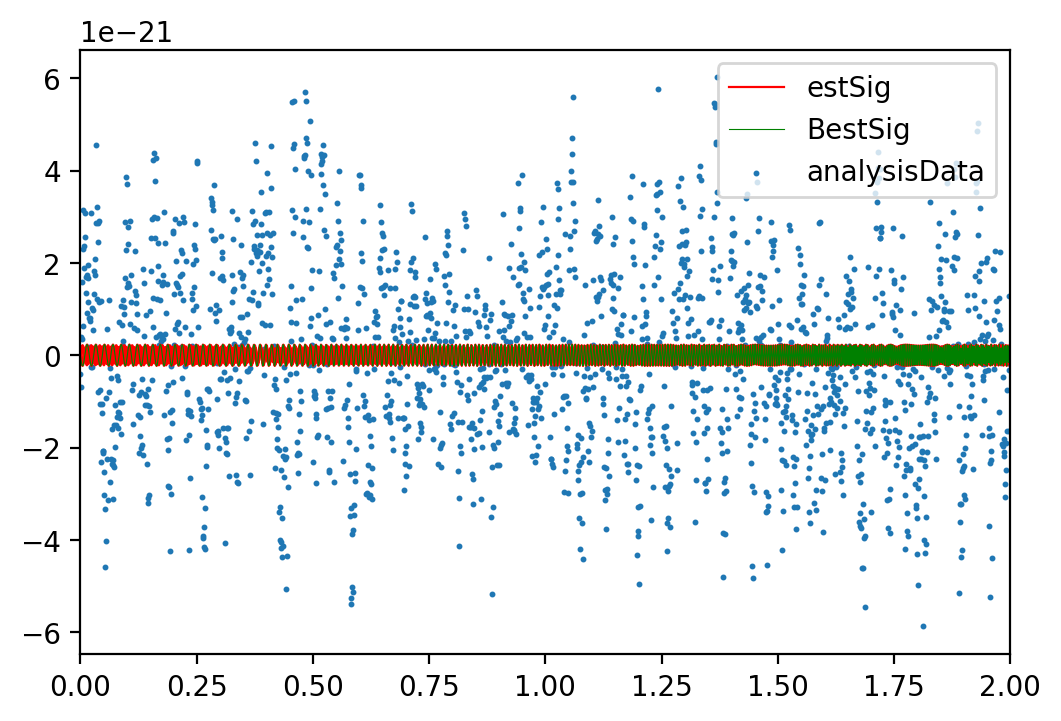

In [6]:
## Plots
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
a=ax.scatter(t, dataY, marker='.', s=5, #label='analysisData'
             )
a.set_label('analysisData')
for lpruns in range(nRuns):
    b,=ax.plot(t, outResults['allRunsOutput'][lpruns]['estSig'],
             color='r', lw=.4*2)
b.set_label('estSig')
c,=ax.plot(t, outResults['bestSig'], #label='BestSig',
         color='g',lw=.2*2)
c.set_label('BestSig')
plt.xlim(0,2)
plt.legend()
plt.savefig('output_sig.png', dpi=200)
plt.show()

In [7]:
# Print estimated parameters
print('Estimated parameters: a1={}; a2={}; a3={}; SNR={}'.format(outResults['bestQcCoefs'][0],
                                                         outResults['bestQcCoefs'][1],
                                                         outResults['bestQcCoefs'][2],
                                                                outResults['bestSNR']))
for lpruns in range(nRuns):
    print('\nRun No.{}:\nbestFitness={:.2f}'.format(lpruns+1, outStruct[lpruns]['bestFitness']) )
    print('a1={:.4f}; a2={:.4f}; a3={:.4f};SNR={:.4f}'.format(outResults['allRunsOutput'][lpruns]['qcCoefs'][0],
                                       outResults['allRunsOutput'][lpruns]['qcCoefs'][1],
                                       outResults['allRunsOutput'][lpruns]['qcCoefs'][2],
                                                  outResults['allRunsOutput'][lpruns]['SNR']))
# Save
np.save('output_results',outResults)
np.save('output_struct',outStruct)

Estimated parameters: a1=51.3605915101784; a2=28.832078856931652; a3=10.308191421692223; SNR=9.056993402304737

Run No.1:
bestFitness=-73.55
a1=52.7682; a2=27.6158; a3=10.6322;SNR=8.5761

Run No.2:
bestFitness=-49.47
a1=56.9549; a2=22.9196; a3=12.1866;SNR=7.0333

Run No.3:
bestFitness=-41.98
a1=63.5777; a2=18.1104; a3=13.3390;SNR=6.4793

Run No.4:
bestFitness=-56.03
a1=46.1993; a2=32.1370; a3=9.6517;SNR=7.4852

Run No.5:
bestFitness=-82.03
a1=51.3606; a2=28.8321; a3=10.3082;SNR=9.0570

Run No.6:
bestFitness=-40.70
a1=73.1083; a2=14.2284; a3=13.4995;SNR=6.3800

Run No.7:
bestFitness=-49.44
a1=55.5727; a2=23.9883; a3=11.9527;SNR=7.0312

Run No.8:
bestFitness=-36.47
a1=75.5552; a2=11.6662; a3=14.2448;SNR=6.0390


9.056993402304737

In [9]:
readdata=np.load('output_results.npy',allow_pickle=True)
print(readdata)

{'allRunsOutput': [{'fitVal': -73.54877418823264, 'qcCoefs': array([52.76816978, 27.61583271, 10.63221497]), 'estSig': array([ 0.00000000e+00,  6.96390558e-23,  1.32091552e-22, ...,
        2.10532553e-22,  1.41010877e-23, -2.16401428e-22]), 'totalFuncEvals': 69378.0, 'SNR': 8.57605819641125}, {'fitVal': -49.46668517795293, 'qcCoefs': array([56.95494793, 22.91960995, 12.18661608]), 'estSig': array([ 0.00000000e+00,  6.14225838e-23,  1.15451628e-22, ...,
        1.75753428e-22, -6.42887191e-24, -1.72696113e-22]), 'totalFuncEvals': 68073.0, 'SNR': 7.033255659931105}, {'fitVal': -41.980719575220654, 'qcCoefs': array([63.57769715, 18.11039408, 13.33898623]), 'estSig': array([ 0.00000000e+00,  6.22422329e-23,  1.15151851e-22, ...,
        5.80693555e-23, -1.62455998e-22,  2.03105890e-23]), 'totalFuncEvals': 68770.0, 'SNR': 6.47925301058854}, {'fitVal': -56.028345693786896, 'qcCoefs': array([46.19933371, 32.13696982,  9.65173387]), 'estSig': array([ 0.00000000e+00,  5.39503414e-23,  1.036511

In [10]:
readdata=np.load('output_struct.npy',allow_pickle=True)
print(readdata)

[{'totalFuncEvals': 69378.0, 'bestLocation': array([52.76816978, 27.61583271, 10.63221497]), 'bestFitness': -73.54877418823264}
 {'totalFuncEvals': 68073.0, 'bestLocation': array([56.95494793, 22.91960995, 12.18661608]), 'bestFitness': -49.46668517795293}
 {'totalFuncEvals': 68770.0, 'bestLocation': array([63.57769715, 18.11039408, 13.33898623]), 'bestFitness': -41.980719575220654}
 {'totalFuncEvals': 69842.0, 'bestLocation': array([46.19933371, 32.13696982,  9.65173387]), 'bestFitness': -56.028345693786896}
 {'totalFuncEvals': 70287.0, 'bestLocation': array([51.36059151, 28.83207886, 10.30819142]), 'bestFitness': -82.02912948939158}
 {'totalFuncEvals': 69826.0, 'bestLocation': array([73.10827509, 14.22837812, 13.49946064]), 'bestFitness': -40.70452531623534}
 {'totalFuncEvals': 70015.0, 'bestLocation': array([55.57265406, 23.98830846, 11.95270317]), 'bestFitness': -49.43843629690297}
 {'totalFuncEvals': 69603.0, 'bestLocation': array([75.55518084, 11.66619353, 14.24475192]), 'bestFitn